<a href="https://colab.research.google.com/github/Teja3993/my-first-repo/blob/main/Rp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --------------------------------------------------
# 1. IMPORT LIBRARIES
# --------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------
# 2. LOAD DATA AND DEFINE COLUMNS
# --------------------------------------------------

# These are the 41 feature names for the NSL-KDD dataset
col_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'target', 'difficulty'
]

# Load the training and testing data
# Make sure to upload 'KDDTrain+.txt' and 'KDDTest+.txt' to your Colab environment
try:
    df_train = pd.read_csv('KDDTrain+.txt', header=None, names=col_names)
    df_test = pd.read_csv('KDDTest+.txt', header=None, names=col_names)
    print("Data loaded successfully.")
    print(f"Training shape: {df_train.shape}")
    print(f"Testing shape: {df_test.shape}")
except FileNotFoundError:
    print("Error: KDDTrain+.txt or KDDTest+.txt not found.")
    print("Please upload the NSL-KDD dataset files to your Colab session.")
    # Exit or raise error

# Drop the 'difficulty' column as it's not a feature
df_train.drop(['difficulty'], axis=1, inplace=True)
df_test.drop(['difficulty'], axis=1, inplace=True)

# --------------------------------------------------
# 3. PREPROCESSING PIPELINE
# --------------------------------------------------

# --- 3.1 Label Mapping (5-Class) ---
# Map all specific attack types to their main categories
# Based on
attacks_types = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
}

df_train['target'] = df_train['target'].apply(lambda x: attacks_types.get(x, 'Other'))
df_test['target'] = df_test['target'].apply(lambda x: attacks_types.get(x, 'Other'))

# Verify distribution
print("\nTraining Data Distribution (Original):")
print(df_train['target'].value_counts())
print("\nTest Data Distribution (Original):")
print(df_test['target'].value_counts())

# --- 3.2 Isolate Categorical and Numerical Features ---
categorical_features = ['protocol_type', 'service', 'flag']
numerical_features = df_train.drop(categorical_features + ['target'], axis=1).columns

# --- 3.3 Scaling Numerical Features ---
scaler = MinMaxScaler()
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])
print("\nNumerical features scaled.")

# --- 3.4 One-Hot Encoding Categorical Features ---
# Combine train and test for encoding to ensure all columns match
combined_df = pd.concat([df_train, df_test])
combined_df = pd.get_dummies(combined_df, columns=categorical_features)

# Separate back into train and test
X_train = combined_df.iloc[:len(df_train)].drop('target', axis=1)
y_train = combined_df.iloc[:len(df_train)]['target']
X_test = combined_df.iloc[len(df_train):].drop('target', axis=1)
y_test = combined_df.iloc[len(df_train):]['target']

# Ensure columns match after encoding
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print(f"Features after One-Hot Encoding: {X_train.shape}")

# --------------------------------------------------
# 4. EXPERIMENT 1: BASELINE (NO SMOTE)
# --------------------------------------------------
print("\n--- Training Baseline Random Forest (No SMOTE) ---")
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

# Predict on the original imbalanced test set
y_pred_baseline = rf_baseline.predict(X_test)

print("\n--- Results for Baseline RF Model (Table 1) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print("\nClassification Report (Baseline):")
print(classification_report(y_test, y_pred_baseline))
print("Confusion Matrix (Baseline):")
print(confusion_matrix(y_test, y_pred_baseline, labels=y_train.unique()))

# --------------------------------------------------
# 5. EXPERIMENT 2: PROPOSED (SMOTE + RF)
# --------------------------------------------------
print("\n--- Applying SMOTE to Training Data ---")
# Instantiate SMOTE.
# SMOTE works on numerical data, which is why it's done *after* encoding.
# Removed 'n_jobs' parameter to fix TypeError
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

print("SMOTE applied.")
print("\nTraining Data Distribution (After SMOTE):")
print(y_train_resampled.value_counts())

print("\n--- Training Proposed Random Forest (with SMOTE) ---")
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_smote.fit(X_train_resampled, y_train_resampled)

# Predict on the original imbalanced test set
y_pred_smote = rf_smote.predict(X_test)

print("\n--- Results for Proposed SMOTE-RF Model (Table 2) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print("\nClassification Report (SMOTE-RF):")
print(classification_report(y_test, y_pred_smote))
print("Confusion Matrix (SMOTE-RF):")
print(confusion_matrix(y_test, y_pred_smote, labels=y_train.unique()))
print("\n--- Experiment Complete ---")

Data loaded successfully.
Training shape: (125973, 43)
Testing shape: (22544, 43)

Training Data Distribution (Original):
target
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

Test Data Distribution (Original):
target
Normal    9711
DoS       5741
Other     3750
R2L       2199
Probe     1106
U2R         37
Name: count, dtype: int64

Numerical features scaled.
Features after One-Hot Encoding: (125973, 122)

--- Training Baseline Random Forest (No SMOTE) ---

--- Results for Baseline RF Model (Table 1) ---
Accuracy: 0.7184

Classification Report (Baseline):
              precision    recall  f1-score   support

         DoS       0.90      0.97      0.94      5741
      Normal       0.65      0.97      0.78      9711
       Other       0.00      0.00      0.00      3750
       Probe       0.62      1.00      0.76      1106
         R2L       0.94      0.02      0.04      2199
         U2R       0.00      0.00      0.00        37


Generating Plot 1: Training Set Class Distribution


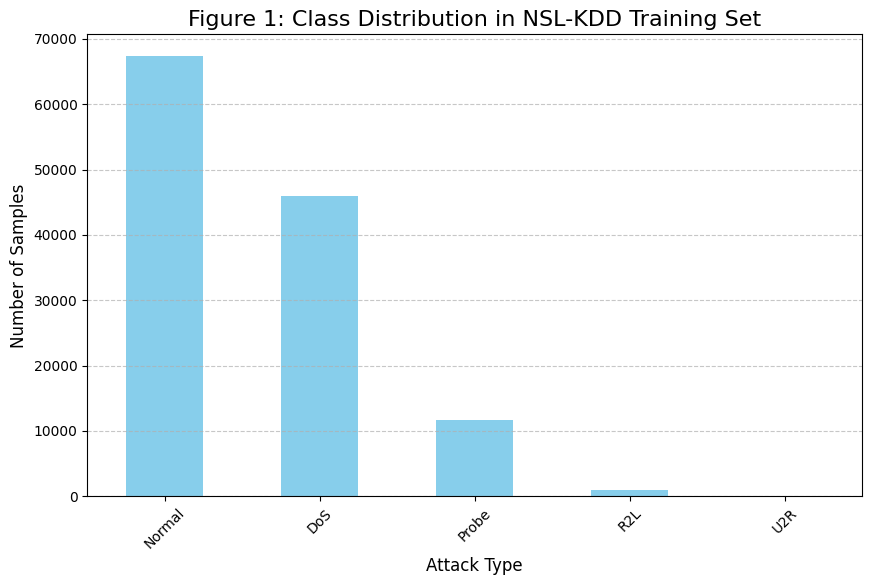


Generating Plot 2: Baseline Confusion Matrix


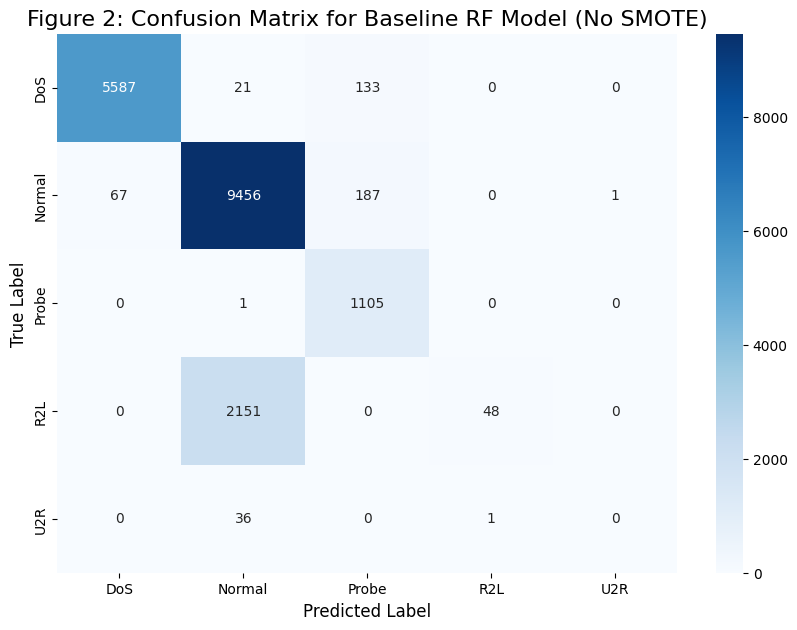


Generating Plot 3: SMOTE-RF Confusion Matrix


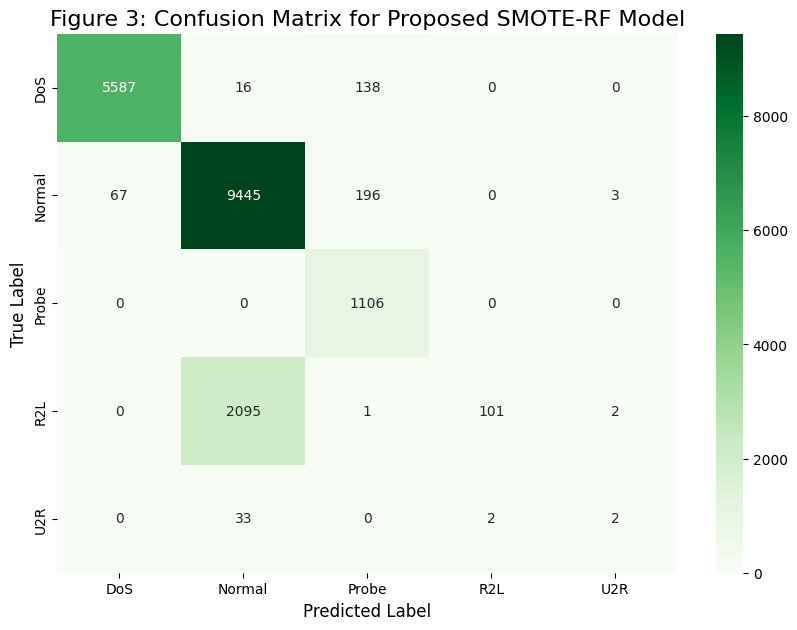


Generating Plot 4: Feature Importances


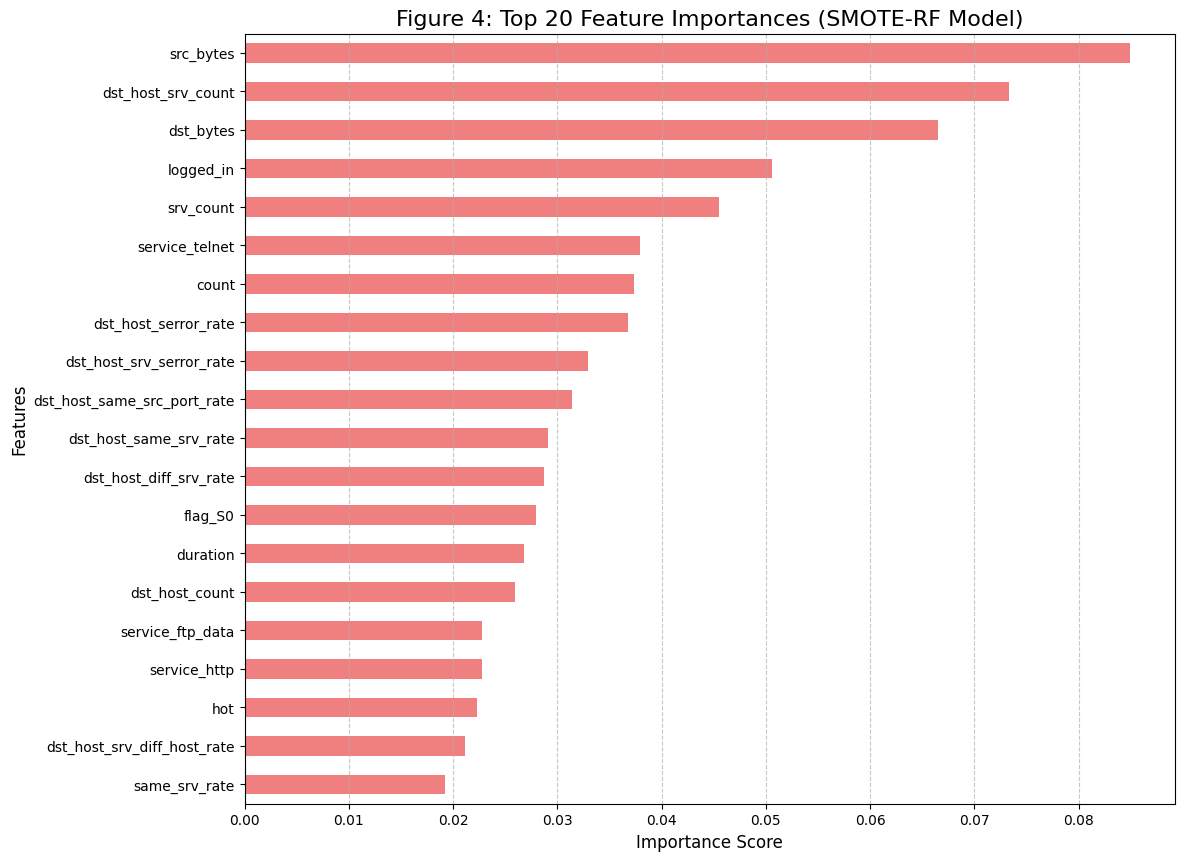


--- Plot Generation Complete ---


In [3]:
# --------------------------------------------------
# 6. PLOTTING FOR VISUALIZATION
# (Run this after the main script)
# --------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot 1: (Figure 1) Class Distribution in Training Set ---
print("\nGenerating Plot 1: Training Set Class Distribution")
plt.figure(figsize=(10, 6))
y_train.value_counts().plot(kind='bar', color='skyblue')
plt.title('Figure 1: Class Distribution in NSL-KDD Training Set', fontsize=16)
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --- Plot 2: (Figure 2) Confusion Matrix for Baseline RF Model ---
print("\nGenerating Plot 2: Baseline Confusion Matrix")
# Get class labels in the correct order
class_labels = sorted(y_train.unique())
cm_baseline = confusion_matrix(y_test, y_pred_baseline, labels=class_labels)
df_cm_baseline = pd.DataFrame(cm_baseline, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm_baseline, annot=True, fmt='d', cmap='Blues')
plt.title('Figure 2: Confusion Matrix for Baseline RF Model (No SMOTE)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


# --- Plot 3: (Figure 3) Confusion Matrix for SMOTE-RF Model ---
print("\nGenerating Plot 3: SMOTE-RF Confusion Matrix")
cm_smote = confusion_matrix(y_test, y_pred_smote, labels=class_labels)
df_cm_smote = pd.DataFrame(cm_smote, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm_smote, annot=True, fmt='d', cmap='Greens')
plt.title('Figure 3: Confusion Matrix for Proposed SMOTE-RF Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


# --- Plot 4: (Figure 4) Feature Importance from SMOTE-RF Model ---
print("\nGenerating Plot 4: Feature Importances")
importances = rf_smote.feature_importances_
feature_names = X_train.columns

# Create a pandas series for easier plotting
feat_importances = pd.Series(importances, index=feature_names)
top_20_features = feat_importances.nlargest(20)

plt.figure(figsize=(12, 10))
top_20_features.plot(kind='barh', color='lightcoral')
plt.title('Figure 4: Top 20 Feature Importances (SMOTE-RF Model)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Plot Generation Complete ---")